In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Masking


2023-12-06 17:47:30.842018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 17:47:30.990699: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 17:47:31.903994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-12-0

## Data

In [2]:
data= pd.read_csv('data/merged.csv')
data.head(5)


,text,is_fake
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


## Preprocess

In [3]:
X= data.text
y= data.is_fake


<Axes: ylabel='Count'>

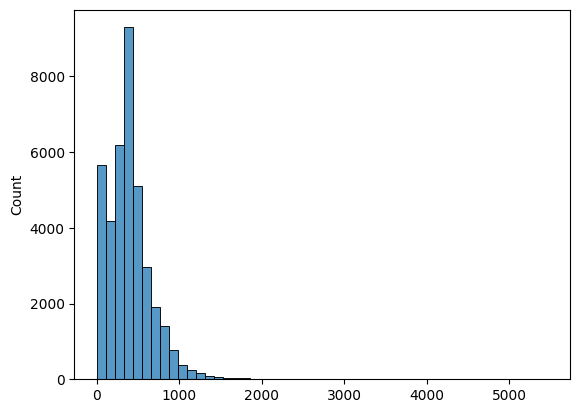

In [4]:
text_len= [len(texts.split()) for texts in data['text']]
sns.histplot(text_len, bins=50)


In [5]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state=42)


In [6]:
X_train.head(5)


34170    Germany will wait for Israeli prosecutors to c...
32020    Two Maldivians suspected of having links to Is...
9181     This bombshell just in is more evidence of the...
35507    LONDONDERRY, Northern Ireland William Jackson ...
13614    Donald Trump won the state of Indiana in a lan...
Name: text, dtype: object

In [7]:
X_train_split= [text_to_word_sequence(t) for t in X_train]


In [8]:
X_test_split= [text_to_word_sequence(t) for t in X_test]


In [9]:
len(X_train_split)


27060

In [10]:
X_trial= X_test_split[0:100]


In [73]:
w2v= Word2Vec(sentences= X_train_split, vector_size=100, window=5)
word= w2v.wv


In [12]:
#word.most_similar('germany')


In [13]:
#len(word.key_to_index)


In [15]:
word['make']


array([-1.0904212e+00, -1.1166930e+00, -2.1644680e-01,  1.0979851e-01,
        6.3740742e-01,  5.1237446e-01, -3.2019036e+00, -9.4369054e-01,
       -4.4362275e-03, -1.2661978e+00, -3.2077935e+00,  7.3227870e-01,
       -4.2353485e-02, -2.5122290e+00, -5.3537685e-01, -2.5612447e+00,
       -3.8377267e-01, -2.4498012e+00, -6.5419036e-01, -4.2750615e-01,
       -3.8106880e-01,  2.5917119e-01, -1.5136760e-01,  2.5822586e-01,
       -3.3896968e-01,  2.7223983e+00, -2.7344327e+00,  6.0505468e-01,
        1.4128008e+00,  2.7106245e+00,  1.9781609e+00,  1.8477416e+00,
       -4.0246177e-01,  9.2065394e-01, -3.4333441e-01, -7.8640425e-01,
       -1.8388469e+00,  1.3310367e+00,  2.3092821e+00,  1.7648098e+00,
        2.1149480e+00,  3.7186716e+00,  7.7547073e-01,  2.1616264e-01,
        1.2355202e+00, -4.3487284e-01,  5.7772942e+00, -5.6806266e-01,
        5.2215617e-02, -3.7404628e+00], dtype=float32)

In [74]:
# Convert the text into a matrix of the words in the embedding space
def embed_sentence(w2v, text):
    embedded_text = []
    for words in text:
        if words in w2v.wv:
            embedded_text.append(w2v.wv[words])

    return np.array(embedded_text)

# Function that converts a list of sentences into a list of matrices
def embedding(w2v, texts):
    embed = []

    for text in texts:
        embedded_text = embed_sentence(w2v, text)
        embed.append(embedded_text)

    return embed

# Embed the training and test sentences
X_train_embed = embedding(w2v, X_train_split)
X_test_embed = embedding(w2v, X_test_split)


In [17]:
#eemax(text_len)


5471

In [18]:
#min(text_len)


0

In [78]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed,truncating='post', maxlen=500)
X_test_pad = pad_sequences(X_test_embed, truncating='post', maxlen=500)


In [79]:
X_train_pad.shape

(27060, 500, 100)

In [80]:
model= Sequential()
model.add(layers.Masking(mask_value=0, input_shape=(500,100)))
model.add(LSTM(15, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


In [81]:
model.fit(X_train_pad, y_new, batch_size=32, epochs=10)


Epoch 1/10
846/846 [==============================] - 165s 190ms/step - loss: 0.1992 - accuracy: 0.9314
Epoch 2/10
846/846 [==============================] - 161s 190ms/step - loss: 0.1182 - accuracy: 0.9658
Epoch 3/10
846/846 [==============================] - 161s 190ms/step - loss: 0.1483 - accuracy: 0.9542
Epoch 4/10
846/846 [==============================] - 161s 191ms/step - loss: 0.1214 - accuracy: 0.9604
Epoch 5/10
846/846 [==============================] - 162s 191ms/step - loss: 0.0833 - accuracy: 0.9746
Epoch 6/10
846/846 [==============================] - 162s 191ms/step - loss: 0.0855 - accuracy: 0.9724
Epoch 7/10
846/846 [==============================] - 162s 192ms/step - loss: 0.0741 - accuracy: 0.9780
Epoch 8/10
846/846 [==============================] - 162s 191ms/step - loss: 0.0694 - accuracy: 0.9787
Epoch 9/10
846/846 [==============================] - 162s 192ms/step - loss: 0.0791 - accuracy: 0.9754
Epoch 10/10
846/846 [==============================] - 162s 192m

In [82]:
model.evaluate(X_test_pad, y_test)

363/363 [==============================] - 18s 46ms/step - loss: 0.0643 - accuracy: 0.9797


[0.06429438292980194, 0.9797378778457642]

In [95]:
data= pd.read_csv('data/merged.csv')

X= data.text
y= data.is_fake

In [96]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state=42)

X_train_split= [text_to_word_sequence(t) for t in X_train]
X_train_split= [text_to_word_sequence(t) for t in X_train]

In [97]:
w2v= Word2Vec(sentences= X_train_split, vector_size=100, window=5)
word= w2v.wv


In [99]:
X_train_embed = embedding(w2v, X_train_split)
X_test_embed = embedding(w2v, X_test_split)

X_train_pad = pad_sequences(X_train_embed,truncating='post', maxlen=500)
X_test_pad = pad_sequences(X_test_embed, truncating='post', maxlen=500)


In [100]:
from keras.callbacks import History, EarlyStopping

history= History()
es= EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train_pad, y_new, batch_size=32, epochs=1000, validation_split=0.2, callbacks=[history, es])

Epoch 1/1000
677/677 [==============================] - 141s 208ms/step - loss: 0.0893 - accuracy: 0.9737 - val_loss: 0.0814 - val_accuracy: 0.9756
Epoch 2/1000
677/677 [==============================] - 140s 207ms/step - loss: 0.0594 - accuracy: 0.9832 - val_loss: 0.0669 - val_accuracy: 0.9790
Epoch 3/1000
677/677 [==============================] - 140s 207ms/step - loss: 0.0611 - accuracy: 0.9830 - val_loss: 0.0740 - val_accuracy: 0.9809
Epoch 4/1000
677/677 [==============================] - 141s 208ms/step - loss: 0.0697 - accuracy: 0.9810 - val_loss: 0.0755 - val_accuracy: 0.9805
Epoch 5/1000
677/677 [==============================] - 140s 207ms/step - loss: 0.0718 - accuracy: 0.9808 - val_loss: 0.0927 - val_accuracy: 0.9746
Epoch 6/1000
677/677 [==============================] - 141s 208ms/step - loss: 0.0758 - accuracy: 0.9787 - val_loss: 0.1026 - val_accuracy: 0.9724
Epoch 7/1000
677/677 [==============================] - 141s 209ms/step - loss: 0.0775 - accuracy: 0.9773 - val_

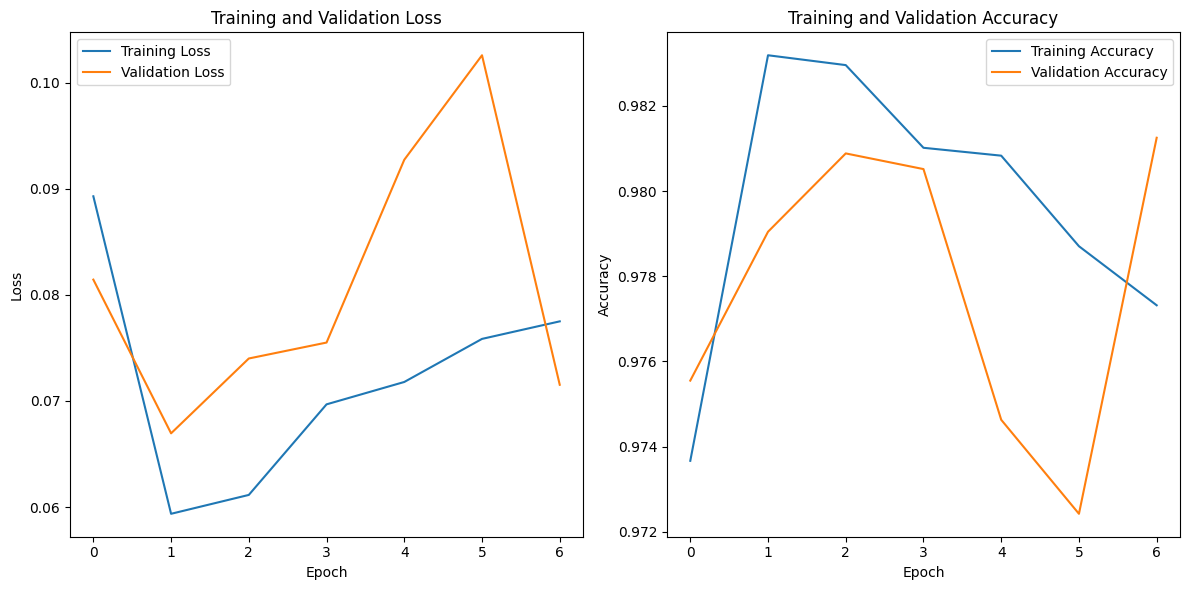

In [101]:
# Plotting the learning curve
def plot_learning_curve(history):
    # Extract training and validation loss and accuracy from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plotting training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Plot the learning curve
plot_learning_curve(history)

In [102]:
df = pd.read_csv('fake_update.csv', quotechar='"')